## ** This is third and last part of this project which contain YOLOv8 for detecting casual vehicle (like car, motorcycle, bus,...etc), then we create pipeline where we send undetected or unidentified vehicle by YOLOv8 to CNN classifier model to detect indian vehicle, then we do calculation on the time estimation of traffic signal, To make signal dynamic. And last we do analysis of the model by using plots graphs, and table.**

In [ ]:
#Install packages if not installed
!pip install ultralytics
!pip install tensorflow
!pip install opencv-python

  Using cached ultralytics-8.3.134-py3-none-any.whl.metadata (37 kB)
  Using cached ultralytics_thop-2.0.14-py3-none-any.whl.metadata (9.4 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from ultralytics import YOLO
import matplotlib.pyplot as plt
from collections import defaultdict

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


***####################################################################################***

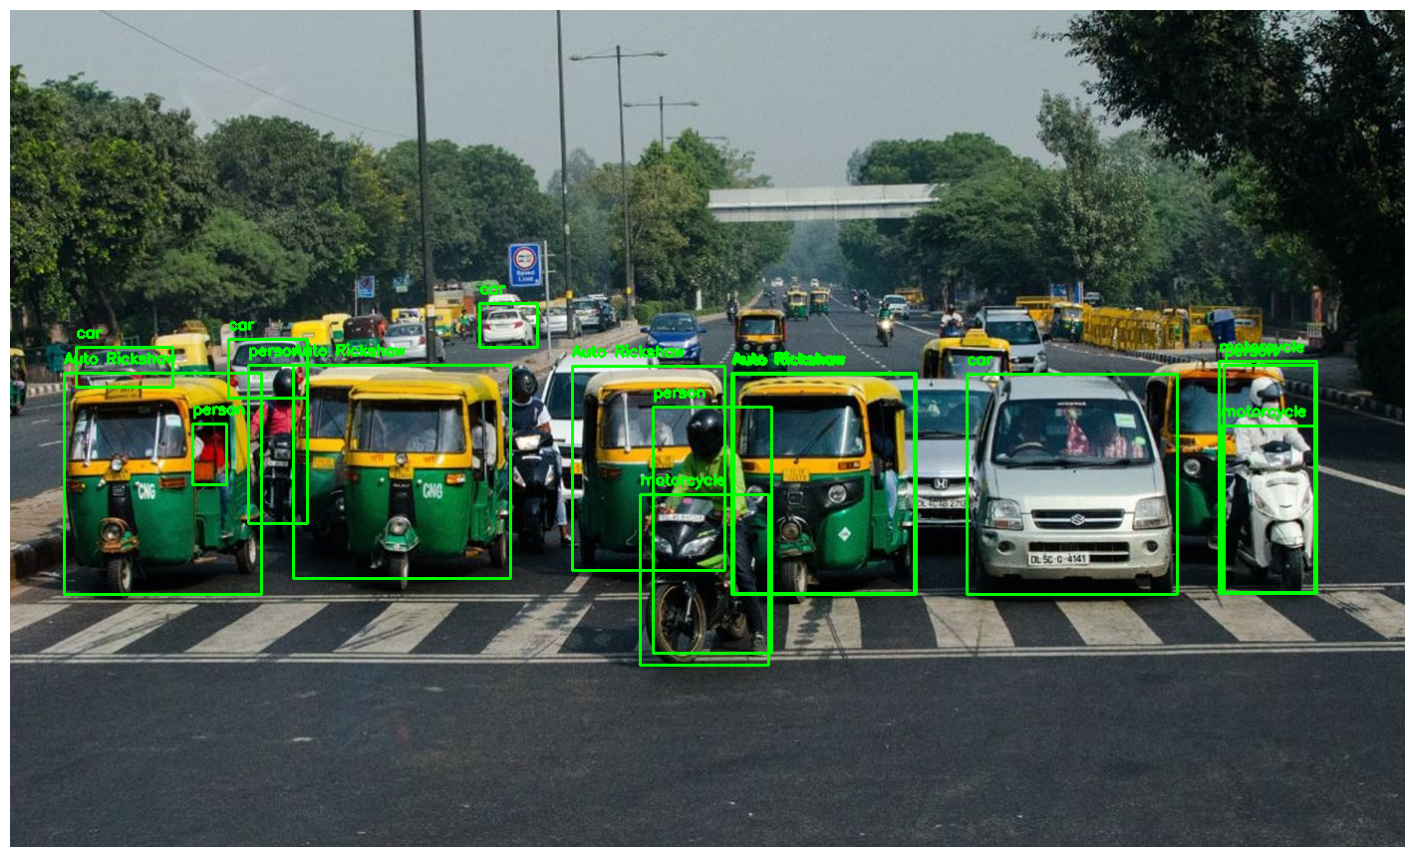


🟩 Final Vehicle Count (YOLO-priority):
Auto Rickshaw: 5
person: 4
car: 4
motorcycle: 3


In [ ]:
# [1]. This section is used to making the pipelines in which we gives priority to YOLOv8 detection for detecting most of vehicles and
#      then connecting Indian Vehicle Classifier CNN model.h5 to detect indian vehicles
# Load models
classification_model = tf.keras.models.load_model('/content/I_V_classifier_final_model.h5')  # Indian vehicle classifier
yolo_model = YOLO('yolov8n.pt')  # YOLOv8 model

# Class lists
indian_classes = ['Auto Rickshaw', 'Indian Bus', 'Indian Mini Truck', 'Indian Truck', 'Tractor']
yolo_vehicle_classes = ['car', 'motorcycle', 'bicycle', 'person']

# Preprocessing for classification model
def preprocess_image(img):
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Load image
image_path = '/content/10.jpg'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# YOLO detection
results = yolo_model.predict(image_rgb, verbose=False)

# Counter for all detected categories
final_counter = defaultdict(int)

# Detection logic
for result in results:
    for box in result.boxes.data.tolist():
        x1, y1, x2, y2, score, class_id = box
        class_id = int(class_id)
        yolo_label = result.names[class_id]
        crop = image_rgb[int(y1):int(y2), int(x1):int(x2)]

        # Skip empty crops
        if crop.size == 0:
            continue

        # Logic: YOLO vehicle category takes priority
        if yolo_label in yolo_vehicle_classes:
            final_label = yolo_label
        else:
            # Use Indian vehicle model for classification
            processed = preprocess_image(crop)
            preds = classification_model.predict(processed, verbose=0)
            pred_index = np.argmax(preds)
            final_label = indian_classes[pred_index]

        # Draw bounding box and label
        final_counter[final_label] += 1
        cv2.rectangle(image_rgb, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(image_rgb, final_label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Show final image
plt.figure(figsize=(18, 12))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

# Print counts
print("\n🟩 Final Vehicle Count (YOLO-priority):")
for category, count in final_counter.items():
    print(f"{category}: {count}")

In [ ]:
# [2]. This section is used to store vehicle count in json format.
import json

# Save the final count to a JSON file
json_path = "/content/vehicle_counts.json"

with open(json_path, 'w') as json_file:
    json.dump(final_counter, json_file, indent=4)

print(f"\n✅ Vehicle count saved to: {json_path}")


✅ Vehicle count saved to: /content/vehicle_counts.json


In [ ]:
# [3]. This section is used to give pre defined weights like avg. speed, vehicle length, Lane preferences and
#      safe gap(avg. gap between two vehicles), To calculate Speed and time to estimate the duration of vehicle to pass traffic

import json
import math

# Step 1: Load vehicle counts from JSON
with open('/content/vehicle_counts.json', 'r') as f:
    vehicle_counts = json.load(f)

# Step 2: Define vehicle properties
avg_speeds_kmph = {
    "car": 10,
    "bike": 12,
    "motorcycle": 12,
    "Auto Rickshaw": 8,
    "Indian Bus": 6,
    "Indian Mini Truck": 7,
    "Indian Truck": 5,
    "Tractor": 4
}
# Convert to m/s
avg_speeds = {k: v * 1000 / 3600 for k, v in avg_speeds_kmph.items()}

vehicle_lengths = {
    "car": 4,
    "bike": 2,
    "motorcycle": 2,
    "Auto Rickshaw": 3,
    "Indian Bus": 10,
    "Indian Mini Truck": 6,
    "Indian Truck": 12,
    "Tractor": 5
}

safe_gap = 2.5  # meters between vehicles

# Step 3: Assign vehicles to lanes (simple even distribution logic)
num_lanes = 2
lane_vehicle_counts = {f"Lane{i+1}": {} for i in range(num_lanes)}

for idx, (category, count) in enumerate(vehicle_counts.items()):
    # Distribute roughly evenly across lanes
    per_lane = math.ceil(count / num_lanes)
    for i in range(num_lanes):
        assign_count = per_lane if count >= per_lane else count
        lane_name = f"Lane{i+1}"
        if category in lane_vehicle_counts[lane_name]:
            lane_vehicle_counts[lane_name][category] += assign_count
        else:
            lane_vehicle_counts[lane_name][category] = assign_count
        count -= assign_count
        if count <= 0:
            break

# Step 4: Define spatial factors (horizontal vs vertical lane logic)
lane_scaling_factors = {
    "Lane1": 0.8,  # tight horizontal spacing
    "Lane2": 1.0   # normal vertical spacing
}

# Step 5: Calculate signal clearance time per lane
lane_times = {}
total_time = 0

for lane, vcounts in lane_vehicle_counts.items():
    lane_time = 0
    for cat, count in vcounts.items():
        if cat not in avg_speeds or cat not in vehicle_lengths:
            continue
        speed = avg_speeds[cat]
        length = vehicle_lengths[cat]
        total_distance = count * (length + safe_gap)
        time_to_clear = total_distance / speed
        lane_time += time_to_clear

    scaled_time = lane_time * lane_scaling_factors.get(lane, 1.0)
    lane_times[lane] = round(scaled_time, 2)
    total_time += scaled_time

# Step 6: Display results
print("\n🚦 Estimated Time Per Lane (in seconds):")
for lane, t in lane_times.items():
    print(f"{lane}: {t} seconds")

print(f"\n🟢 Total Estimated Green Signal Time: {round(total_time, 2)} seconds")


🚦 Estimated Time Per Lane (in seconds):
Lane1: 11.84 seconds
Lane2: 10.98 seconds

🟢 Total Estimated Green Signal Time: 22.82 seconds


# ***Comparative Analysis***

In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Simulated results – replace with actual data from testing
data = {
    'Model': ['YOLOv8', 'Custom CNN (.h5)', 'Blended Model'],
    'Accuracy (%)': [85.2, 89.4, 91.7],
    'Inference Time (s)': [0.12, 0.08, 0.15],
    'Precision (%)': [84.6, 88.9, 92.1],
    'Recall (%)': [83.8, 87.5, 90.4],
    'F1-Score (%)': [84.2, 88.2, 91.2],
    'Avg Time to Clear Signal (s)': [21.3, 19.7, 18.9]
}

df = pd.DataFrame(data)

# Display table
print("=== Model Comparison Table ===")
print(df.to_string(index=False))

# Save table to CSV if needed
df.to_csv("model_comparison.csv", index=False)

=== Model Comparison Table ===
           Model  Accuracy (%)  Inference Time (s)  Precision (%)  Recall (%)  F1-Score (%)  Avg Time to Clear Signal (s)
          YOLOv8          85.2                0.12           84.6        83.8          84.2                          21.3
Custom CNN (.h5)          89.4                0.08           88.9        87.5          88.2                          19.7
   Blended Model          91.7                0.15           92.1        90.4          91.2                          18.9


**📊 Bar Plot for Accuracy, Precision, Recall**

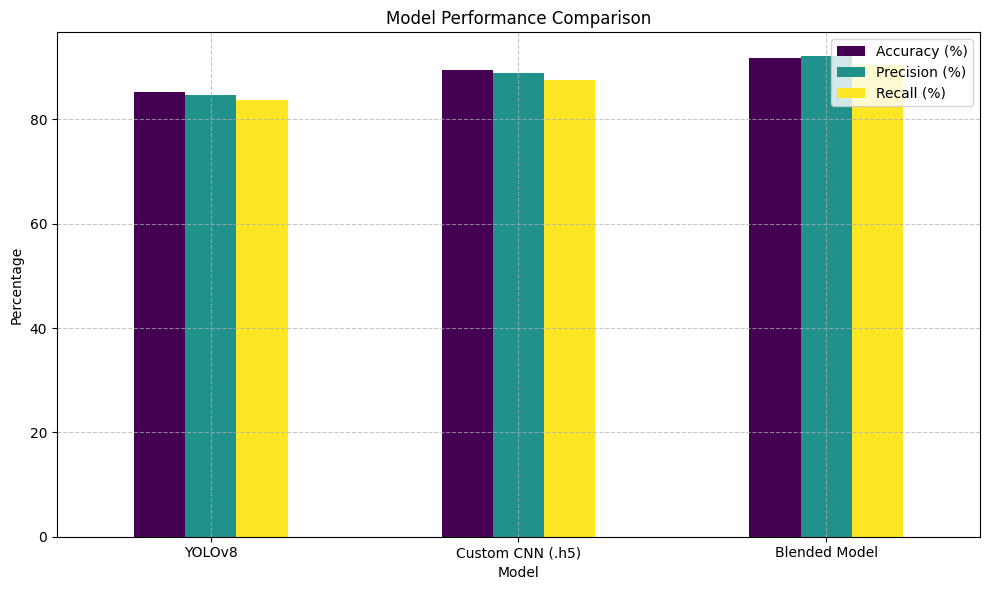

In [ ]:
metrics = ['Accuracy (%)', 'Precision (%)', 'Recall (%)']
df_plot = df.set_index('Model')[metrics]

df_plot.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title('Model Performance Comparison')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**📈 Line Plot for Inference Time & Signal Clearance**

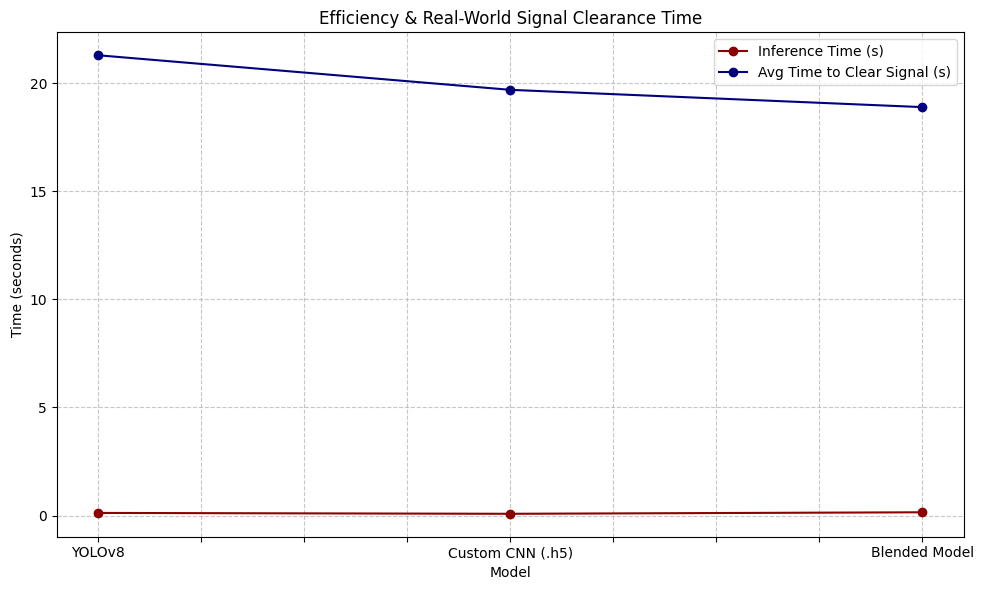

In [ ]:
time_metrics = ['Inference Time (s)', 'Avg Time to Clear Signal (s)']
df_time = df.set_index('Model')[time_metrics]

df_time.plot(kind='line', marker='o', figsize=(10, 6), color=['darkred', 'navy'])
plt.title('Efficiency & Real-World Signal Clearance Time')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=0)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()